<a href="https://colab.research.google.com/github/akhilesh008/AIML-Training-Akhilesh/blob/main/HW_day_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST data plotting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
# Supporting functions
#@title

from IPython.display import Latex as lt
#Plotting functions
#(You DON'T need to understand how these functions)

# function to plot a grid
def plotGrid(transform, unit, linestyle = ':', fig=None, ax=None):
  lim1 = -100
  lim2 = 100
  def mat2xy(start, end):
    if len(start.shape)==1:
      start = np.expand_dims(start,0)
      end = np.expand_dims(end,0)
    nan = np.ones(len(start))*np.nan
    x = np.stack((start[:,0], end[:,0], nan)).T.reshape(-1)
    y = np.stack((start[:,1], end[:,1], nan)).T.reshape(-1)
    return x, y

  def parallellines(axis, addend, lines, unit):
    addend = np.repeat(np.expand_dims(addend,0), lines*2, 0)
    unit = np.expand_dims(np.arange(-lines, lines)*unit,1)
    unit = unit-lines
    addend = addend*unit
    lines = np.expand_dims(axis,0) + addend
    return np.concatenate((lines, lines*-1))

  if fig is None:
    fig, ax = plt.subplots(figsize=(10,10))
  transform = transform.astype(np.float)
  xaxis = transform[0]
  yaxis = transform[1]

  # plot lines parallel to the x axis
  lines1= parallellines(xaxis*lim1, yaxis, 100,unit )
  lines2 = parallellines(xaxis*lim2, yaxis, 100,unit )
  x,y = mat2xy(lines1, lines2)
  plt.plot(x,y, linestyle+'k', linewidth=0.5)
  # plot x axis
  x,y = mat2xy(xaxis*lim1, xaxis*lim2)
  plt.plot(x,y,linestyle, color = '#440077')

  # plot  lines parallel to the y axis
  lines1= parallellines(yaxis*lim1, xaxis, 100,unit)
  lines2 = parallellines(yaxis*lim2, xaxis, 100,unit)
  x,y = mat2xy(lines1, lines2)
  plt.plot(x,y, linestyle+'k', linewidth=0.5)
  # plot y axis
  x,y = mat2xy(yaxis*lim1, yaxis*lim2)
  plt.plot(x,y,linestyle, color= '#aa5500')

  return fig, ax

def plotData(X, y, xlabel = 'hole', ylabel = 'bound', fig=None, ax = None):

  if fig is None:
    fig, ax = plt.subplots()
  for ii in range(nclasses):
    plt.scatter(X[y==ii,0], X[y==ii, 1])
  plt.legend([str(i) for i in range(nclasses)])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  lim2 = X.max()
  lim1 = X.min()
  add = abs(lim1-lim2)/5
  return fig, ax

### Transforming MNIST data

In [4]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

def cumArray(img):
  img2 = img.copy()
  for ii in range(1, img2.shape[1]):
    img2[ii,:] = img2[ii,:] + img2[ii-1,:]  # for every row, add up all the rows above it.
  img2 = img2>0
  return img2

def getHolePixels(img):
  im1 = cumArray(img)
  im2 = np.rot90(cumArray(np.rot90(img)), 3) # rotate and cumulate it again for differnt direction
  im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
  im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
  hull =  im1 & im2 & im3 & im4 # this will create a binary image with all the holes filled in.
  hole = hull & ~ (img>0) # remove the original digit to leave behind the holes
  return hole

def getHullPixels(img):
  im1 = cumArray(img)
  im2 = np.rot90(cumArray(np.rot90(img)), 3) # rotate and cumulate it again for differnt direction
  im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
  im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
  hull =  im1 & im2 & im3 & im4 # this will create a binary image with all the holes filled in.
  return hull

def minus(a, b):
  return a & ~ b

def getBoundaryPixels(img):
  img = img.copy()>0  # binarize the image
  rshift = np.roll(img, 1, 1)
  lshift = np.roll(img, -1 ,1)
  ushift = np.roll(img, -1, 0)
  dshift = np.roll(img, 1, 0)
  boundary = minus(img, rshift) | minus(img, lshift) | minus(img, ushift) | minus(img, dshift)
  return boundary

### Get the MNIST data

In [8]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

nclasses = 4

# get only for the first 4 classes
train_X = train_X[train_y<nclasses]
train_y = train_y[train_y<nclasses]
test_X = test_X[test_y<nclasses]
test_y = test_y[test_y<nclasses]

train_X = train_X[::100].copy() # We are only taking a subset of the training set
train_y = train_y[::100].copy() # do the same to the labels
test_X = test_X[::100].copy() # taking a subset of the test set. This code takes every 500th sample
test_y = test_y[::100].copy()

# get all the features
train_hole = np.array([getHolePixels(i).sum() for i in train_X])
test_hole = np.array([getHolePixels(i).sum() for i in test_X])
train_bound = np.array([getBoundaryPixels(i).sum() for i in train_X])
test_bound = np.array([getBoundaryPixels(i).sum() for i in test_X])

# create the train and test set by combining the appropriate features
train_feats = np.vstack((train_hole,train_bound)).transpose()
test_feats = np.vstack((test_hole, test_bound)).transpose()

(-100.0, 300.0)

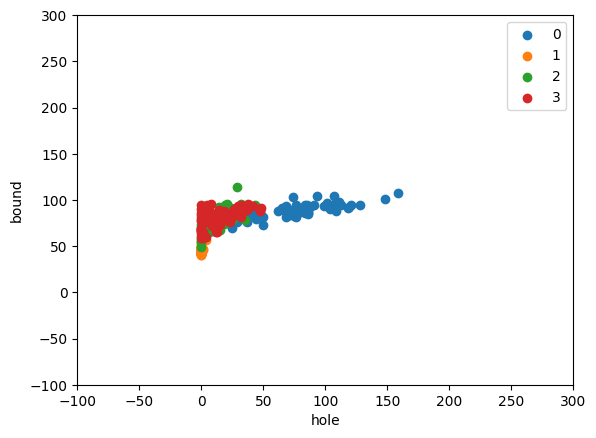

In [9]:
# fix limits of x and y axis so that we can see what is going on
xlim=[-100,300]
ylim=[-100,300]
fig, ax = plotData(train_feats, train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [10]:
# test the accuracy
test_pred = NN(train_feats, train_y, test_feats)
acc = Accuracy(test_y, test_pred)
print('Baseline accuracy = ', acc)

Baseline accuracy =  0.7619047619047619


### Transforming the features and checking the accuracy

In [46]:
#transform = np.array([[0.5,-0.5],[0,2.5]])
transform = np.array([[0.5,-0.5],[-0.5,2.5]])

train_feats_t = np.matmul(train_feats, transform)
test_feats_t = np.matmul(test_feats, transform)  # whatever transform we are applying to the training set should be applied to the test set also

In [47]:
print(transform)

[[ 0.5 -0.5]
 [-0.5  2.5]]


(-100.0, 300.0)

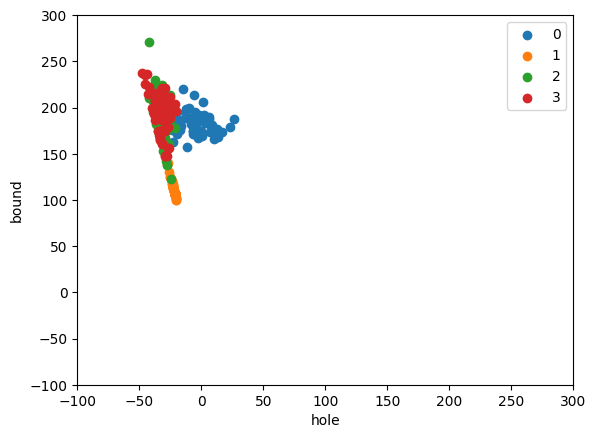

In [48]:
fig, ax = plotData(train_feats_t, train_y)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [49]:
test_pred = NN(train_feats_t, train_y, test_feats_t)
acc = Accuracy(test_y, test_pred)
print('Accuracy after transform = ', acc)

Accuracy after transform =  0.8095238095238095
